# Analysis of 2018 NYC Marathon Finishers

Mei Guan, meiguan, yg833

## Problem Description:
The first New York City Marathon was organized in 1970 with only 127 entrants in Central Park where 55 men finished and the only female entrant dropped out due to illness, according to the NYRR site (here). This year (2018) marks the 48th year of the race and it has grown to include more than 52K finishers who ran the race with an average time of 4:40:22. And many of these 2018 NYC finishers would hopefully qualify for entry into the 2020 Boston Marathon which is much sought after. 

With this context, I am interested in learning more about the NYC Marathon Finishers-- who they are, where they come from, and their overall race performance. From this analysis of Marathon Finishers, I want to answer the question of what is the rate of Men vs. Women NYC marathon finishers who can meet the qualification standards for the Boston Marathon in 2020? Is there a difference in the qualifying rates between the genders especially considering the differing gender and age group time qualifiers as published by the Boston Athletics Association (https://www.baa.org/races/boston-marathon/enter/qualify)? 

Note: The difference seems to be more generous to women and the older age groups. 


## Data: 
For this analysis, I will be doing some web-scraping to collect data on the 2018 marathon finishers from the New York Road Runners site: https://results.nyrr.org/event/M2018/finishers Through this link, we can find out information such as name, age, gender, country of origin, splits, and overall finish time. 

After obtaining this data, I will perform some basic exploratory data analysis to understand the dataset. I may also have to create some added features such as positive and negative splits to see how runners performed between segments of the race. I will also have to compare the finishing times to the published Boston Marathon qualifying times per gender and age group. 

In [113]:
# import the necessary libraries for this analysis.
from __future__  import print_function, division
import os
import datetime as dt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import mixture

%matplotlib inline
from IPython.display import Image


In [2]:
#pd.read_csv('nyc2018marathonfinishers.csv')
runners_df = pd.read_csv('nyc2018marathonfinishers.csv', sep=',' , encoding='latin-1')

In [3]:
runners_df.shape

(79998, 21)

In [4]:
runners_df.dropna(inplace=True)

In [5]:
runners_df.shape
# compare the length of the before and after arrays

(51570, 21)

#### Comment on Data Collection:
After dropping NaNs, it appears more than 28K observations were dropped from the dataset. This is expected mainly because during the data collection phase I observed that the each of the URLs corresponds to a BIB #s and since the site only reports on Finishers, individuals who may have qualified to run the race may not actually have started or completed the race. The NYRR site only reported a total of 52,705 runners who finished the race. During the data collection process, I also saw that there were pages without a full set of records meaning that not every split was timestamped. I did not collect those observations. By this math, 97% of all finishers were collected during the data collection process. 

#### Parse out the text columns into separate fields

In [6]:
runners_df['gender'] = runners_df.age_gender.str[11:12]

In [7]:
runners_df['age'] = runners_df.age_gender.str[12:14].astype(int)

In [8]:
runners_df['bib_team'] = runners_df.age_gender.str[15:]

In [9]:
runners_df['country'] = runners_df.runner.str[-3:]

In [10]:
runners_df['state'] = np.where(runners_df['country'] == 'USA', 
                               runners_df.runner.str[-8:-6], 'Out of USA')

In [11]:
temp_locale = runners_df.runner.str[:-6].str.split(' ', expand=True)

In [12]:
temp_locale.columns = ['temp0', 'temp1', 'temp2', 'temp3', 'temp4', 'temp5',\
                       'temp6', 'temp7', 'temp8', 'temp9', 'temp10']

In [13]:
for i in temp_locale.columns:
    temp_locale[i] = np.where(temp_locale[i].str.contains(","), 
                              temp_locale[i].str[:-1], temp_locale[i])

In [14]:
find_city_columns = ['temp2', 'temp3', 'temp4', 'temp5', \
                     'temp6', 'temp7', 'temp8', 'temp9', 'temp10']

In [15]:
for i in find_city_columns:
    temp_locale[i] = np.where(temp_locale[i].str.isupper(), temp_locale[i], None)

In [16]:
temp_locale['locale'] = temp_locale['temp2'] + ' ' + temp_locale['temp3'] + ' ' + \
                        temp_locale['temp4'] + ' ' + temp_locale['temp5'] + ' ' + \
                        temp_locale['temp6'] + ' ' + temp_locale['temp7']  + ' ' + \
                        temp_locale['temp8'] + ' ' + temp_locale['temp9'] + ' ' + temp_locale['temp10']

In [17]:
temp_locale['country'] = runners_df['country']

In [18]:
temp_o_time = runners_df.official_time.str.split(':', expand=True)
temp_o_time.columns = ['h','m','s']

In [19]:
temp_o_time['fin_time_sec'] = temp_o_time['h'].astype(int)*60*60 + \
                            temp_o_time['m'].astype(int)*60 + temp_o_time['s'].astype(int)

In [20]:
runners_df['fin_time_sec'] = temp_o_time['fin_time_sec']

In [21]:
w_runners_df = runners_df.copy(deep=True)

In [22]:
w_runners_df.columns

Index(['runner', 'age_gender', 'official_time', 'pace_per_mile',
       'place_overall', 'place_gender', 'place_age_group', 'place_age_graded',
       'time_age_graded', 'percentile_age_graded', 'gun_time', 'gun_place',
       'splits_5k', 'splits_10k', 'splits_15K', 'splits_20K', 'splits_half',
       'splits_25k', 'splits_30k', 'splits_35k', 'splits_40k', 'gender', 'age',
       'bib_team', 'country', 'state', 'fin_time_sec'],
      dtype='object')

In [23]:
w_runners_df.drop(['runner', 'age_gender', 'official_time', 'bib_team',
                   'place_gender', 'place_age_group', 'place_age_graded',
                   'time_age_graded', 'percentile_age_graded', 'gun_time', 'gun_place',
                   'splits_5k', 'splits_10k', 'splits_15K', 'splits_20K', 'splits_half',
                   'splits_25k', 'splits_30k', 'splits_35k', 'splits_40k'], axis=1, inplace=True)

## Exploratory Data Analysis
This is to provide an understanding of the dataset, what are the interested variables and the general descriptive statistics of the variables.

In [24]:
w_runners_df.head()

,pace_per_mile,place_overall,gender,age,country,state,fin_time_sec
0,4:50,"3 of 52,705",M,25,KEN,Out of USA,7586
1,4:49,"2 of 52,705",M,22,ETH,Out of USA,7561
2,4:49,"1 of 52,705",M,28,ETH,Out of USA,7559
3,4:55,"4 of 52,705",M,27,ETH,Out of USA,7710
4,4:59,"5 of 52,705",M,26,KEN,Out of USA,7821


In [25]:
w_runners_df.describe()

,age,fin_time_sec
count,51570.000000,51570.000000
mean,41.196432,16612.842273
std,10.747250,3383.247357
min,18.000000,5781.000000
25%,33.000000,14196.000000
50%,41.000000,16285.000000
75%,49.000000,18658.000000
max,88.000000,36306.000000


In [26]:
w_runners_df.groupby(['gender'])['gender'].count() # total 51570

gender
F    21548
M    30022
Name: gender, dtype: int64

Text(0, 0.5, 'Finish Time Seconds')

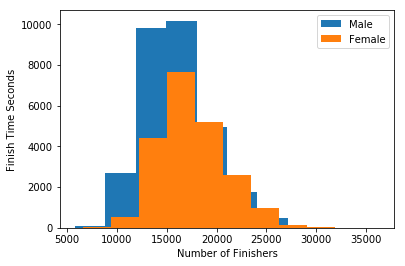

In [27]:
plt.hist(w_runners_df['fin_time_sec'][w_runners_df['gender'] == 'M'], label='Male')
plt.hist(w_runners_df['fin_time_sec'][w_runners_df['gender'] == 'F'], label='Female')
plt.legend(loc='best')
plt.xlabel('Number of Finishers')
plt.ylabel('Finish Time Seconds')

#### Figure 1: Histogram of Finishers and Finish Time in Seconds By Gender. It looks like Males finish the race at a shorter time than Females. 

In [28]:
w_runners_df.groupby(['gender']).describe()

age                                                      \
          count       mean        std   min   25%   50%   75%   max   
gender                                                                
F       21548.0  39.363746  10.499081  18.0  30.0  39.0  47.0  88.0   
M       30022.0  42.511825  10.730820  18.0  34.0  42.0  50.0  81.0   

       fin_time_sec                                                       \
              count          mean          std     min      25%      50%   
gender                                                                     
F           21548.0  17530.532810  3244.855181  6627.0  15202.0  17175.0   
M           30022.0  15954.178769  3326.677164  5781.0  13610.0  15613.0   

                           
             75%      max  
gender                     
F       19580.25  34696.0  
M       17895.00  36306.0

## IDEA: 
### Considering the qualifying times for men and women published by the Boston Athletic Association for Qualification for the 2020 Boston Marathon, it appears that the Women's times are more generous for each age group by about 30 minutes. With this, Women is more likely to qualify for the 2020 Boston Marathon with their NYC Marathon race time than Men.

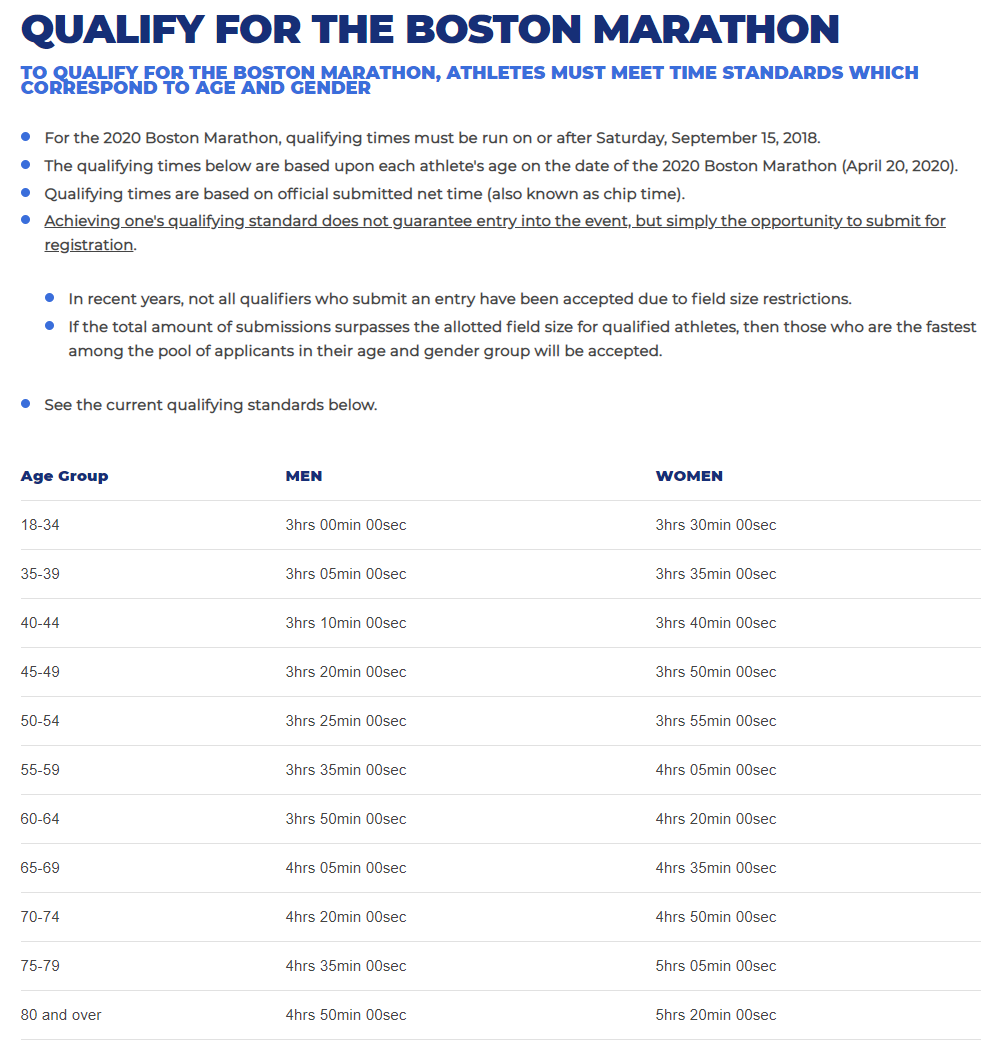

In [29]:
Image("BAA_Qualify.PNG")

## NULL HYPOTHESIS:
### The proportion of men qualifying is _the same_ or _higher_  than the proportion of women qualifying

### _$H_0$_ : $\frac{W_{\mathrm{qualify}}}{W_{\mathrm{total}}} <= \frac{M_{\mathrm{qualify}}}{M_{\mathrm{total}}}$
### _$H_1$_ : $\frac{W_{\mathrm{qualify}}}{W_{\mathrm{total}}} > \frac{M_{\mathrm{qualify}}}{M_{\mathrm{total}}}$

### I will use a significance level  $\alpha=0.05$
#### which means I want the probability of getting a result at least as significant as mine to be less then 5%

In [30]:
# create df for male qualifying times
m_qual_times = {'age': range(18,100)}
m_qual_times = pd.DataFrame(data=m_qual_times)
m_qual_times['mq_time'] = np.where(m_qual_times['age'] < 35, 3*60*60, 
                         np.where(m_qual_times['age'] < 40, 3*60*60+5*60,
                         np.where(m_qual_times['age'] < 45, 3*60*60+10*60, 
                         np.where(m_qual_times['age'] < 50, 3*60*60+20*60,
                         np.where(m_qual_times['age'] < 55, 3*60*60+25*60,
                         np.where(m_qual_times['age'] < 60, 3*60*60+35*60,
                         np.where(m_qual_times['age'] < 65, 3*60*60+50*60,
                         np.where(m_qual_times['age'] < 70, 4*60*60+5*60,
                         np.where(m_qual_times['age'] < 75, 4*60*60+20*60,
                         np.where(m_qual_times['age'] < 80, 4*60*60+35*60,
                                  4*60*60+50*60))))))))))
m_qual_times.shape

(82, 2)

In [31]:
# create df for female qualifying times
f_qual_times = {'age': range(18,100)}
f_qual_times = pd.DataFrame(data=f_qual_times)
f_qual_times['fq_time'] = np.where(f_qual_times['age'] < 35, 3*60*60+30*60, 
                         np.where(f_qual_times['age'] < 40, 3*60*60+35*60,
                         np.where(f_qual_times['age'] < 45, 3*60*60+40*60, 
                         np.where(f_qual_times['age'] < 50, 3*60*60+50*60,
                         np.where(f_qual_times['age'] < 55, 3*60*60+55*60,
                         np.where(f_qual_times['age'] < 60, 4*60*60+5*60,
                         np.where(f_qual_times['age'] < 65, 4*60*60+20*60,
                         np.where(f_qual_times['age'] < 70, 4*60*60+35*60,
                         np.where(f_qual_times['age'] < 75, 4*60*60+50*60,
                         np.where(f_qual_times['age'] < 80, 5*60*60+5*60,
                                  5*60*60+20*60))))))))))
f_qual_times.shape

(82, 2)

In [32]:
bq_times = pd.merge(m_qual_times, f_qual_times, how='inner', on=['age', 'age'])

In [34]:
w_runners_df_bq = pd.merge(w_runners_df, bq_times, how='left', on=['age', 'age'])

In [35]:
w_runners_df_bq['bos_marathon'] = np.where((w_runners_df_bq['gender'] == 'M') & (w_runners_df_bq['fin_time_sec'] <= w_runners_df_bq['mq_time']), 1,
                                  np.where((w_runners_df_bq['gender'] == 'F') & (w_runners_df_bq['fin_time_sec'] <= w_runners_df_bq['fq_time']), 1, 0))         

In [36]:
w_runners_df_bq['gender_encoded'] = np.where((w_runners_df_bq['gender'] == 'M'), 0, 1) # males are 0 and females are 1

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered 

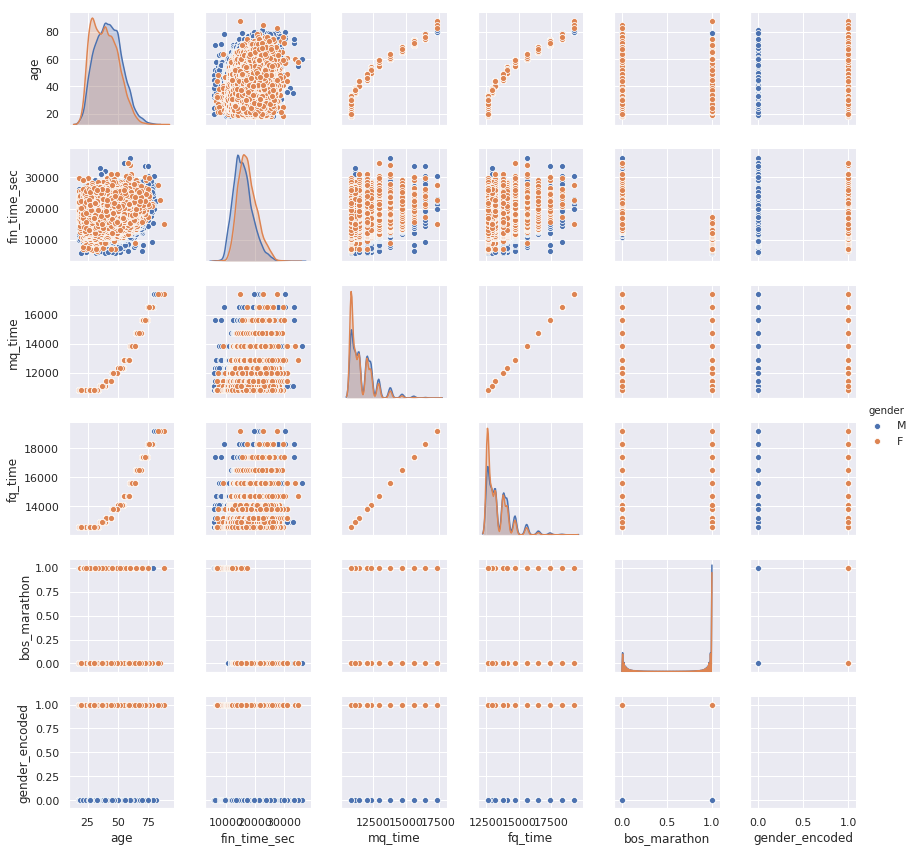

In [37]:
sns.set()
sns.pairplot(w_runners_df_bq, hue='gender', size=2)

In [38]:
w_runners_df_bq.head()

,pace_per_mile,place_overall,gender,age,country,state,fin_time_sec,mq_time,fq_time,bos_marathon,gender_encoded
0,4:50,"3 of 52,705",M,25,KEN,Out of USA,7586,10800,12600,1,0
1,4:49,"2 of 52,705",M,22,ETH,Out of USA,7561,10800,12600,1,0
2,4:49,"1 of 52,705",M,28,ETH,Out of USA,7559,10800,12600,1,0
3,4:55,"4 of 52,705",M,27,ETH,Out of USA,7710,10800,12600,1,0
4,4:59,"5 of 52,705",M,26,KEN,Out of USA,7821,10800,12600,1,0


In [39]:
w_runners_df_bq['bos_marathon'].value_counts()

0    47534
1     4036
Name: bos_marathon, dtype: int64

In [48]:
w_runners_df_bq.groupby(['gender','bos_marathon'])['bos_marathon'].count()

gender  bos_marathon
F       0               19933
        1                1615
M       0               27601
        1                2421
Name: bos_marathon, dtype: int64

In [95]:
# number of runners per gender group
f = w_runners_df_bq[w_runners_df_bq['gender']=='F']['gender'].count()
m = w_runners_df_bq[w_runners_df_bq['gender']=='M']['gender'].count()

In [96]:
# number of runners per gender group who qualified for 2020 marathon
f_bos = w_runners_df_bq[(w_runners_df_bq['gender']=='F') & (w_runners_df_bq['bos_marathon']==1)]['gender'].count()
m_bos = w_runners_df_bq[(w_runners_df_bq['gender']=='M') & (w_runners_df_bq['bos_marathon']==1)]['gender'].count()

In [102]:
# fraction of men and women
f_frac = f_bos / f
error_f = np.sqrt(f)
m_frac = m_bos / m
error_m = np.sqrt(m)

Text(0, 0.5, 'Fraction of Runners Who Qualified')

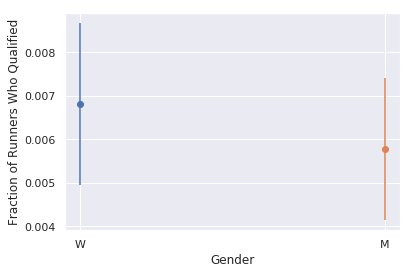

In [105]:
fig = plt.figure(0)
plt.errorbar(x = 'W', y = error_f / f, yerr=np.sqrt(f_bos)/f, fmt='o')
plt.errorbar(x = 'M', y = error_m / m, yerr=np.sqrt(m_bos)/m, fmt='o')
plt.xlabel('Gender')
plt.ylabel('Fraction of Runners Who Qualified')

#### Figure 2: ....

In [106]:
def evalChisq(sample_values):
    diag_product_1 = sample_values.diagonal().prod()
    diag_product_2 = np.fliplr(sample_values).diagonal().prod()
    diag_diff_sqrt = (diag_product_1 - diag_product_2)**2
    tot = sample_values.sum()
    row_sums = sample_values.sum(axis = 1).prod()
    col_sums = sample_values.sum(axis = 0).prod()
    
    return (diag_diff_sqrt*tot)/ (row_sums * col_sums)

#### Contingency Table

|qualify for Boston Marathon|     yes   | no        |                   
|---------------------------|-----------|-----------|----------------|
|Female Runners             | 1615      |19933      |             |
|Male Runners               |2421       |27601      |             |
|                           |           |           |                |
| total                     | 4036      | 47534     |             |

In [110]:
Ntot = f + m
sample_values = np.array([[ f_bos, f - f_bos], [m_bos, m - m_bos]])
print (evalChisq(sample_values))

5.633840951338535


In [111]:
# degree of freedom = (number of rows -1 )(number of columns -1 )
dof = (2-1) * (2-1)
dof

1

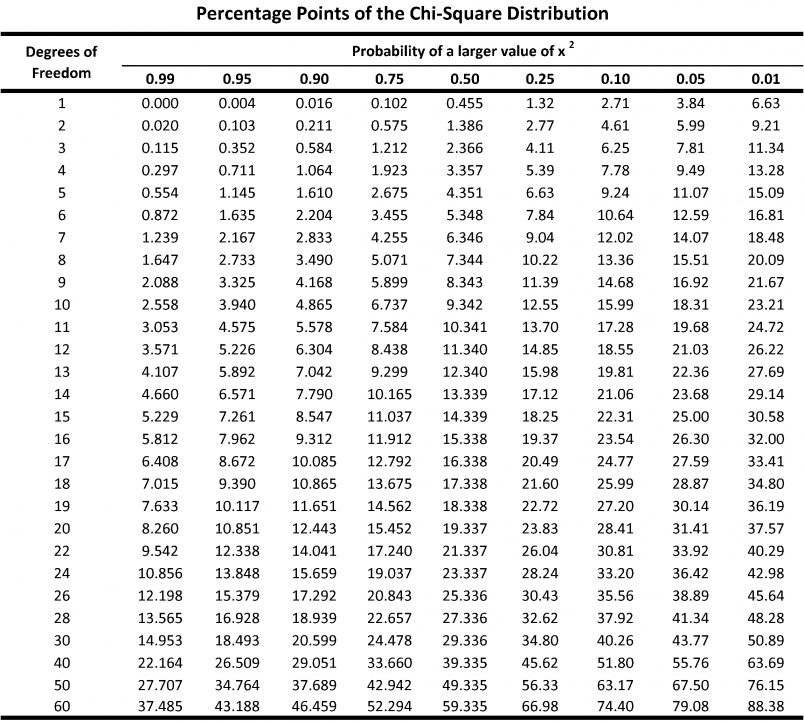

In [112]:
Image("http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG")

## Notes & Observations
* p-value for a dof of 1 and alpha = 0.05, significance level is 3.84 according to the table above for Percentage Points of the Chi-Square Distribution
* 5.63 > 3.84 
* which means that the p value less than 0.05
* Therefore can reject NULL hypothesis: "NULL HYPOTHESIS: The proportion of men qualifying is _the same_ or _higher_  than the proportion of women qualifying, significance level p=0.05"

In [40]:
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
# Class count
count_class_0, count_class_1 = w_runners_df_bq.bos_marathon.value_counts()

# Divide by class
df_class_0 = w_runners_df_bq[w_runners_df_bq['bos_marathon'] == 0]
df_class_1 = w_runners_df_bq[w_runners_df_bq['bos_marathon'] == 1]

In [42]:
df_class_0_under = df_class_0.sample(count_class_1)

In [43]:
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

Random under-sampling:
1    4036
0    4036
Name: bos_marathon, dtype: int64


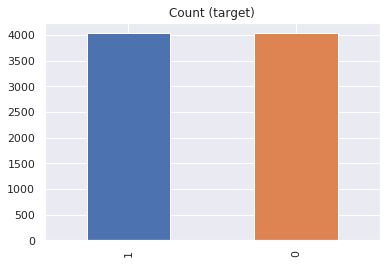

In [46]:
print('Random under-sampling:')
print(df_test_under.bos_marathon.value_counts())

df_test_under.bos_marathon.value_counts().plot(kind='bar', title='Count (target)');

In [47]:
X = df_test_under.loc[:, ['gender_encoded', 'age']].copy()
y = df_test_under['bos_marathon']

In [48]:
# array of 4 features in order:
# slope of line, x- intercept, mean of ts/ normedtsmean, std of ts/ normedtsstd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

X_train.head()

,gender_encoded,age
1956,0,60
21424,0,33
3326,0,46
1042,0,45
35752,1,25


In [50]:
np.bincount(y_train)

array([2704, 2704])

In [51]:
clf = rfc(random_state = 10, n_estimators=100)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [52]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [53]:
clf.score(X_test,y_test)

0.5401651651651652

In [54]:
y_pred = clf.predict(X_test)

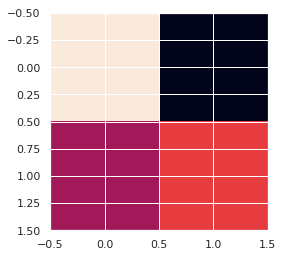

In [61]:
plt.imshow(confusion_matrix(y_test, y_pred))

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.57      0.55      1332
           1       0.54      0.51      0.53      1332

   micro avg       0.54      0.54      0.54      2664
   macro avg       0.54      0.54      0.54      2664
weighted avg       0.54      0.54      0.54      2664

